In [6]:
%load_ext autoreload
%autoreload 2
%aimport -numpy
%aimport -torch
%aimport -gym

import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
torch.manual_seed(0)

# for saving/loading
import os

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from Train_policy_func import Policy, Policy_v2, device
from Generate_traj_func import generate_trajectory
from Plot_Functions import plot_suboptimality, plot_trajectory_performance, plot_Scores
from PPO import ppo_update, RolloutBuffer, evaluate_policy

# Training loop for OPPO
from OPPO import baseline_CartPole_V0, baseline_MountainCar, OPPO_update
from OPPO import baseline_1, baseline_CartPole_v0_Fla
from PPO_Fla import *
from pairs_generator import extract_states_actions, compute_reward_from_traj

In [8]:
# _oppo = 0.01
# env_name = 'CartPole-v0'
# env_oppo   = gym.make(env_name)

# pi1_oppo = Policy(state_size=env_oppo.observation_space.shape[0],
#                      action_size=env_oppo.action_space.n).to(device)
# opt1_oppo    = torch.optim.Adam(pi1_oppo.parameters(), lr=lr_oppo)

# pi2_oppo = Policy(state_size=env_oppo.observation_space.shape[0],
#                      action_size=env_oppo.action_space.n).to(device)
# opt2_oppo   = torch.optim.Adam(pi2_oppo.parameters(), lr=lr_oppo)


# # ── Load the policies if you want to reuse them ──
# pi1_oppo.load_state_dict(torch.load(f"pi1_oppo_{env_name}.pth"))
# pi2_oppo.load_state_dict(torch.load(f"pi2_oppo_{env_name}.pth"))


# obs_dim = gym.make(env_name).observation_space.shape[0]
# act_dim = gym.make(env_name).action_space.n

# # Step 1: Use your reference policy from OPPO
# reference_policy = PolicyNetwork(obs_dim, act_dim)
# # Optionally load weights: reference_policy.load_state_dict(torch.load("oppo_cartpole.pth"))

# # Step 2: Generate trajectories from it
# trajectories = generate_trajectories(reference_policy, env_name, n_episodes=20)

# # Step 3: Generate preference pairs (simulated)
# pairs = generate_trajectory_pairs(trajectories)

# # Step 4: Train reward model from preferences
# reward_model = RewardModel(obs_dim)
# train_reward_model(pairs, reward_model)

# # Step 5: Train new PPO policy with learned reward
# new_policy = PolicyNetwork(obs_dim, act_dim)
# ppo_with_learned_reward(env_name, new_policy, reward_model)


In [9]:
def score_trajectory(traj, reward_model, device='cpu'):
    """
    traj: list of (s, a, r, s', done)
    reward_model: torch model mapping state -> scalar
    """
    states = torch.FloatTensor([s for (s, _, _, _, _) in traj]).to(device)
    with torch.no_grad():
        scores = reward_model(states).squeeze()  # [T]
    return scores.cpu().numpy()  # returns array of rewards per timestep

def plot_reward_score(traj, reward_model, title="Reward model score"):
    rewards = score_trajectory(traj, reward_model)
    plt.figure(figsize=(10,4))
    plt.plot(rewards, label="RM Score")
    plt.xlabel("Timestep")
    plt.ylabel("Predicted reward")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def compare_pairwise_reward(traj_a, traj_b, reward_model):
    score_a = score_trajectory(traj_a, reward_model).sum()
    score_b = score_trajectory(traj_b, reward_model).sum()
    print(f"Total RM Score: A = {score_a:.2f}, B = {score_b:.2f}")
    preferred = "A" if score_a > score_b else "B"
    print(f"→ Model prefers: {preferred}")


def main(env_name='CartPole-v0', seed=42, n_episodes=200, compare_episodes=100, ref=1):
    print(f"🚀 Starting PPO-RLHF pipeline on {env_name} with seed={seed}")
    
    # Set up the environment
    env = gym.make(env_name)

    # Seeding for reproducibility
    set_seed(seed, env)

    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n
    env.close()  # close after shape inference

    # Step 1: Reference policy (OPPO-trained or just initialized here)
    pi_ref = Policy_v3(state_size= obs_dim, action_size=act_dim).to(device)
    
    # Load the reference policy (either pi1 or pi2, from a previous OPPO run)
    pi_ref.load_state_dict(torch.load(f"pi{ref}_oppo_{env_name}.pth"))
    print(f"pi{ref}_oppo loaded")


    # pi_untrained = Policy_v3(state_size= obs_dim, action_size=act_dim).to(device)

    # Step 2: Generate trajectories from pi_ref
    trajectories = generate_trajectories(pi_ref, env_name, n_episodes=n_episodes)
    # trajectories_untrained = generate_trajectories(pi_untrained, env_name, n_episodes=20)


    # Step 3: Preference Pairs (simulated)
    pairs = generate_trajectory_pairs(trajectories)
    pairs_test = generate_trajectory_pairs(trajectories)
    # Step 4: Train reward model
    reward_model = RewardModel(obs_dim)
    train_reward_model(pairs, reward_model, epochs=100)
    
    plot_reward_score(trajectories_test[0], reward_model, title="Reward model score for trajectory 1")
    plot_reward_score(trajectories_test[1], reward_model, title="Reward model score for trajectory 2")

    compare_pairwise_reward(trajectories_test[0], trajectories_test[1], reward_model)
    # Step 5: Train new policy using PPO and learned reward
    pi_rlhf = Policy_v3(obs_dim, act_dim)
    pi_rlhf.load_state_dict(torch.load(f"pi{ref}_oppo_{env_name}.pth"))

    ppo_with_learned_reward(env_name, pi_rlhf, reward_model, epochs=10)

    # Step 6: Compare policies
    compare_policies(env_name, pi_ref, pi_rlhf, n_episodes=compare_episodes, seed=seed)






***

Function to test scores on CartPole-v0 with seed=42
pi1_oppo loaded as reference policy
Reward model loaded


c:\Users\flako\anaconda3\Lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\Users\flako\anaconda3\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\flako\anaconda3\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


PPO Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Evaluating policies over 100 episodes with seed 42...

📊 Results:
OPPO policy (pi_ref):   avg reward = 183.05, success rate = 73/100
PPO-RLHF (pi_rlhf):     avg reward = 9.46, success rate = 0/100


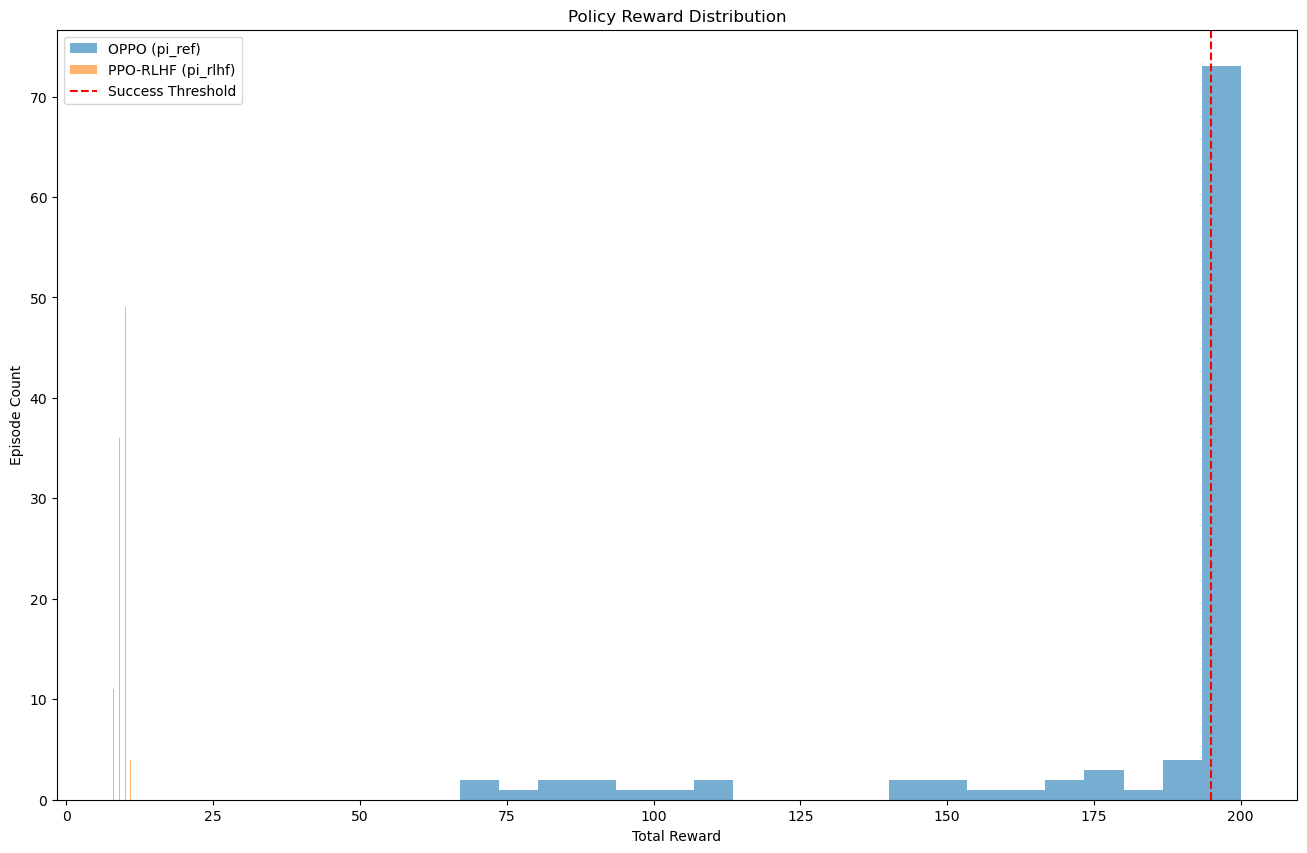

In [ ]:
from pair_gen_version_youss import *
from RLHF_Fla import *
def test_score(env_name='CartPole-v0', seed=42, reward_model_name=None, n_pairs=200, compare_episodes=100, ref=1, n_epoch_rm=50):
    print(f"Function to test scores on {env_name} with seed={seed}")
    
    # Set up the environment
    env = gym.make(env_name)

    # Seeding for reproducibility
    set_seed(seed, env)

    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.n

    # Step 1: Reference policy (OPPO-trained or just initialized here)
    pi_ref = Policy_v3(state_size= obs_dim, action_size=act_dim).to(device)
    
    # Load the reference policy (either pi1 or pi2, from a previous OPPO run)
    pi_ref.load_state_dict(torch.load(f"pi{ref}_oppo_{env_name}.pth"))
    print(f"pi{ref}_oppo loaded as reference policy")


    # Step 2: Generate trajectories from pi_ref
    # trajectories = generate_trajectories(pi_ref, env_name, n_episodes=n_episodes)
    # trajectories_untrained = generate_trajectories(pi_untrained, env_name, n_episodes=n_episodes)
    # print("Trajectories generated")


    # Step 3: Preference Pairs (simulated)
    # pairs = generate_trajectory_pairs(trajectories)
    # Step 4: Train reward model
    if reward_model_name is None:
        # Generate trajectories for training the reward model
        print("Generating trajectories for training the reward model")
        pi_untrained = Policy_v3(state_size= obs_dim, action_size=act_dim).to(device)
        pi_untrained.load_state_dict(torch.load(f"pi2_oppo_{env_name}.pth"))
        Dataset = generate_preference_datasets(pi_ref, pi_untrained, env, nb_traj_pairs=n_pairs, max_steps=500)
        print("Dataset generated")
        print(f"Dataset size: {len(Dataset)} (number of pair = number of trajectories)")
        reward_model = RewardModel(obs_dim, act_dim)
        optim_rm = Adam(reward_model.parameters(), lr=1e-3)
        print("Reward model initialized, training of the model starts")
        
        train_reward_model(reward_model, Dataset, optim_rm, epochs=n_epoch_rm)
        print("Reward model trained")
        # Save the model
        torch.save(reward_model.state_dict(), f"reward_model_ppo_Fla_{env_name}.pth")
    else:
        reward_model = RewardModel(obs_dim, act_dim)
        reward_model.load_state_dict(torch.load(reward_model_name))
        print("Reward model loaded")
    #     reward_model.load_state_dict(torch.load(f"reward_model_ppo_Fla_{env_name}.pth"))
    # plot_reward_score(trajectories_test[0], reward_model, title="Reward model score for trajectory 1")
    # plot_reward_score(trajectories_test[1], reward_model, title="Reward model score for trajectory 2")

    # compare_pairwise_reward(trajectories_test[0], trajectories_test[1], reward_model)
    # Step 5: Train new policy using PPO and learned reward
    pi_rlhf = Policy_v3(obs_dim, act_dim)
    # pi_rlhf.load_state_dict(torch.load(f"pi{ref}_oppo_{env_name}.pth"))
    # pi_rlhf.load_state_dict(torch.load(f"pi2_oppo_{env_name}.pth"))

    ppo_with_learned_reward(env_name, pi_rlhf, reward_model, epochs=300)

    # Step 6: Compare policies
    compare_policies(env_name, pi_ref, pi_rlhf, n_episodes=compare_episodes, seed=seed)


env_name = 'CartPole-v0'
# rm_name = None
rm_name = f"reward_model_ppo_Fla_{env_name}.pth"

test_score(env_name=env_name, seed=42, reward_model_name=rm_name, n_pairs=200, compare_episodes=100, ref=1)


***

In [ ]:
# env_name = 'CartPole-v1'
# env = gym.make(env_name)


# pi_ref = Policy_v3(state_size=env.observation_space.shape[0],
#                      action_size=env.action_space.n).to(device)
# pi_ref.load_state_dict(torch.load(f"pi1_oppo_{env_name}.pth"))

# pi_ref2 = Policy_v3(state_size=env.observation_space.shape[0],
#                      action_size=env.action_space.n).to(device)
# pi_ref2.load_state_dict(torch.load(f"pi2_oppo_{env_name}.pth"))


# n_episodes = 50
# # r_1 = evaluate_policy(env_name, pi_ref, n_episodes=n_ep, seed=42)
# # r_2 = evaluate_policy(env_name, pi_ref2, n_episodes=n_ep, seed=42)

# # compare_policies(env_name, pi_ref, pi_ref2, n_episodes=n_episodes, seed=42, success_threshold=490)



c:\Users\flako\anaconda3\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\flako\anaconda3\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
# states = pi_ref.state_dict()
# print("states:", states)
# print("min state:", torch.min(states), "max state:", torch.max(states))

🚀 Starting PPO-RLHF pipeline on CartPole-v1 with seed=42
pi2_oppo loaded


C:\Users\flako\AppData\Local\Temp\ipykernel_11724\1792810134.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  states = torch.FloatTensor([s for (s, _, _, _, _) in traj]).to(device)


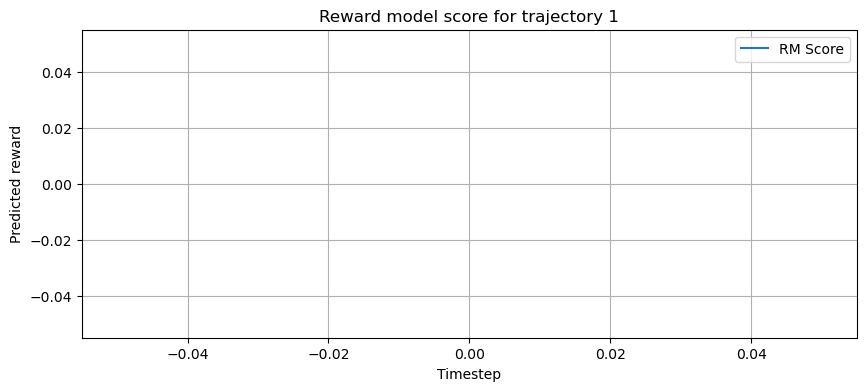

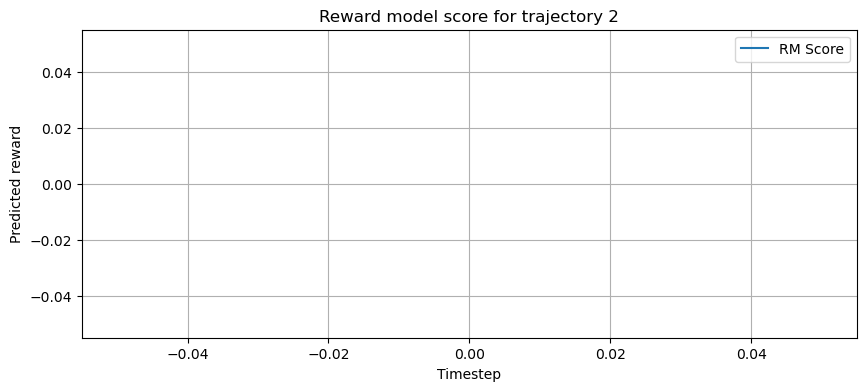

Total RM Score: A = nan, B = nan
→ Model prefers: B


c:\Users\flako\anaconda3\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\flako\anaconda3\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


NaNs found in logits!
Evaluating policies over 100 episodes with seed 42...


ValueError: Expected parameter logits (Tensor of shape (1, 2)) of distribution Categorical(logits: torch.Size([1, 2])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan]], grad_fn=<SubBackward0>)

In [ ]:
# env_name = 'CartPole-v1'
# # main(env_name=env_name, seed=42, n_episodes=20, compare_episodes=100, ref=1)
# main(env_name=env_name, seed=42, n_episodes=20, compare_episodes=100, ref=2)


🚀 Starting PPO-RLHF pipeline on CartPole-v1 with seed=42
pi1_oppo loaded
Evaluating policies over 100 episodes with seed 42...

📊 Results:
OPPO policy (pi_ref):   avg reward = 445.94, success rate = 91/100
PPO-RLHF (pi_rlhf):     avg reward = 436.31, success rate = 88/100


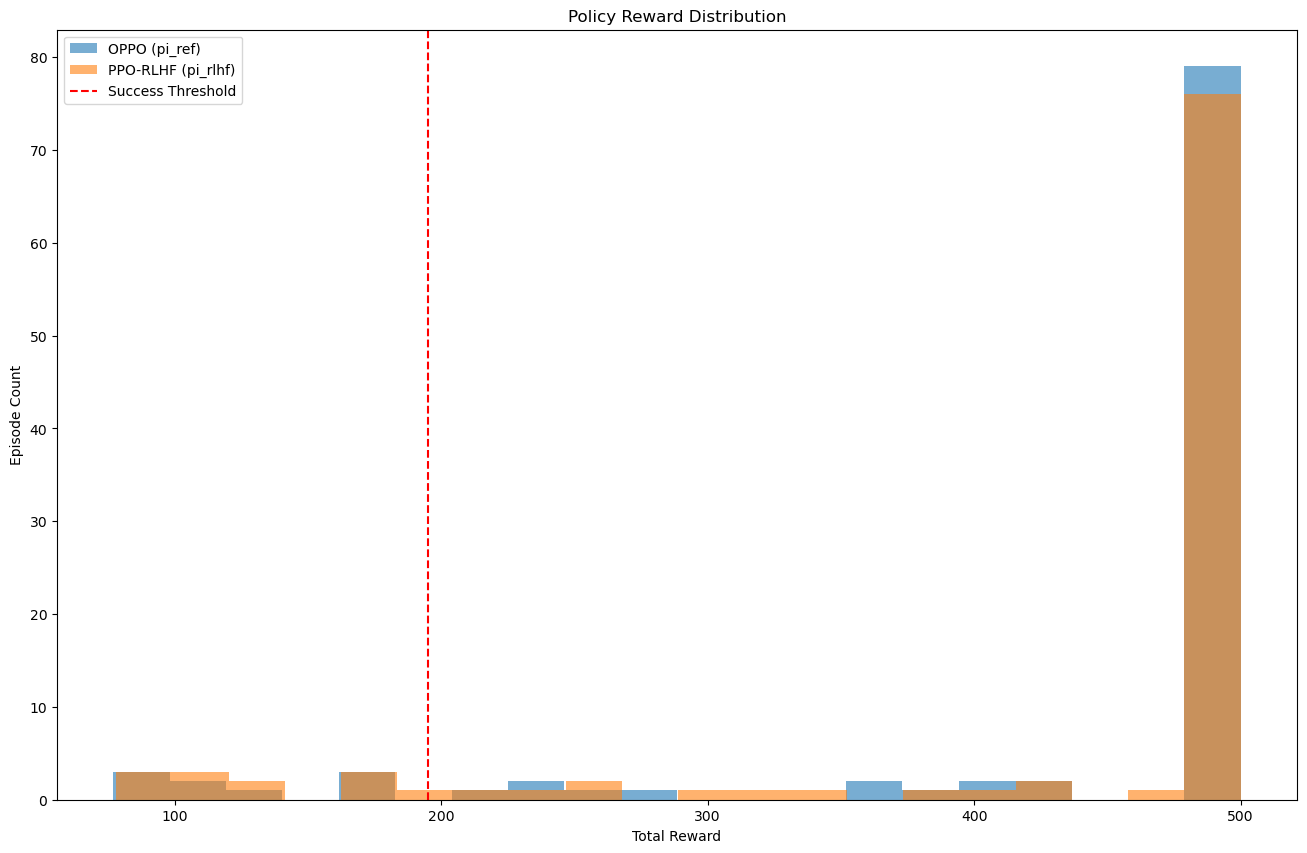

🚀 Starting PPO-RLHF pipeline on CartPole-v1 with seed=42
pi2_oppo loaded
NaNs found in logits!
Evaluating policies over 100 episodes with seed 42...


ValueError: Expected parameter logits (Tensor of shape (1, 2)) of distribution Categorical(logits: torch.Size([1, 2])) to satisfy the constraint IndependentConstraint(Real(), 1), but found invalid values:
tensor([[nan, nan]], grad_fn=<SubBackward0>)

In [ ]:
# env_name = 'CartPole-v1'
# main(env_name=env_name, seed=42, n_episodes=20, compare_episodes=100, ref=1)
# main(env_name=env_name, seed=42, n_episodes=20, compare_episodes=100, ref=2)


In [ ]:

# from PPO_Fla import ppo_update_fla, RolloutBuffer

# updates = 200
# actor_length = 16
# traj_length = 500
# c1 = 0.1822
# c2 = 0.0377
# clip_eps = 0.1
# gamma, lam = 0.9157, 0.8329
# lr = 0.0016595613641357258
# batch_size = 47
# epochs = 6

# env_name = "CartPole-v1"
# # decaying entropy coefficient
# entropy_coef_start = 0.01
# entropy_coef_end   = 1e-4      # 0 or a small floor like 1e-4
# max_updates = updates 

# # Instantiate
# env       = gym.make(env_name)
# env.reset(seed=0)

# pi_ref2 = Policy_v3(state_size=env.observation_space.shape[0],
#                      action_size=env.action_space.n).to(device)
# pi_ref2.load_state_dict(torch.load(f"pi2_oppo_{env_name}.pth"))

# policy    = Policy_v3().to(device)
# # policy.load_state_dict(torch.load(f"pi2_oppo_{env_name}.pth"))

# optimizer = optim.Adam(policy.parameters(), lr=lr)
# PPO_reward_per_update = []
# buffer = RolloutBuffer()

# eval_every = 50 # every how many updates to evaluate the policy
# eval_curve   = []

# for update in tqdm(range(updates)):
#     buffer.clear() # clear the buffer for the next batch of trajectories
#     avg_returns = []
#     actor_rewards     = []

#     # 1) Collect trajectories
#     for N in range(actor_length):
#         state = env.reset() 
#         steps = 0
#         done = False
#         # for tracking episode returns within this batch
#         current_ep_reward   = 0.0
#         reward_per_actor = []
        
#         # 1.1 one trajectory per actor
#         while not done: # < traj_length or done == False:
#             action, logp, value = policy.act(state)
#             next_state, reward, done, _ = env.step(action)
#             buffer.store(state, action, logp, reward, value, done)
#             state = next_state
#             steps += 1


#             # accumulate for this episode
#             current_ep_reward += reward

#             # if done:
#             #     actor_rewards.append(current_ep_reward)
#             #     current_ep_reward = 0.0
#             #     state = env.reset() 
#             #     # break


#         avg_ret = np.mean(actor_rewards)
#         avg_returns.append(avg_ret)

#     if update % eval_every == 0:
#         rewards = evaluate_policy(env_name, policy, n_episodes=20)
#         mean_eval = np.mean(rewards)
#         eval_curve.append((update, mean_eval))
#         print(f"[Update {update}] mean score over {n_episodes} = {mean_eval:.1f}")


#     PPO_reward_per_update.append(np.mean(actor_rewards))

#     # # 2) Compute last value (for GAE)     -> done in ppo_update ? I think so
#     # _, last_value = policy(torch.from_numpy(state).float().unsqueeze(0).to(device))

#     # 2.5) Linear-decay schedule:
#     # frac = 1.0 - (update - 1) / float(max_updates)
#     # c2 = entropy_coef_end + frac * (entropy_coef_start - entropy_coef_end)

#     half = max_updates // 2
#     if update <= half:
#         c2 = entropy_coef_start * (1.0 - (update - 1) / half)
#     else:
#         c2 = 0.0


#     # 3) PPO update
#     ppo_update_fla(policy, optimizer, buffer,gamma,lam,c1, c2, clip_eps, epochs, batch_size)

#     # 4) Saving checkpoint of the policy to get pi2
#     # if (update ) % 20 == 0 : # and update < updates/2
#     #     print(f"Update {update}/{updates} completed. Average return: {np.mean(actor_rewards)}")
#     #     # save the policy
#     #     torch.save(policy.state_dict(), f"pi2_checkpoint_{update}.pth")

# # 5) at the end, save pi1
# torch.save(policy.state_dict(), f"pi_ppo_{env_name}.pth")
# print(f"Saved final policy as pi_ppo_{env_name}.pth")




# # compare_policies(env_name, pi_ref, pi_ref2, n_episodes=n_episodes, seed=42, success_threshold=490)


  0%|          | 0/200 [00:00<?, ?it/s]

[Update 0] mean score over 50 = 22.0


 25%|██▌       | 50/200 [00:56<05:27,  2.18s/it]

[Update 50] mean score over 50 = 98.9


 50%|█████     | 100/200 [02:50<03:55,  2.36s/it]

[Update 100] mean score over 50 = 114.8


 75%|███████▌  | 150/200 [05:05<02:29,  2.99s/it]

[Update 150] mean score over 50 = 130.6


100%|██████████| 200/200 [06:56<00:00,  2.08s/it]

Saved final policy as pi_ppo_CartPole-v1.pth


Evaluating policies over 50 episodes with seed 42...

📊 Results:
OPPO policy (pi_ref):   avg reward = 379.60, success rate = 19/50
PPO-RLHF (pi_rlhf):     avg reward = 157.54, success rate = 0/50


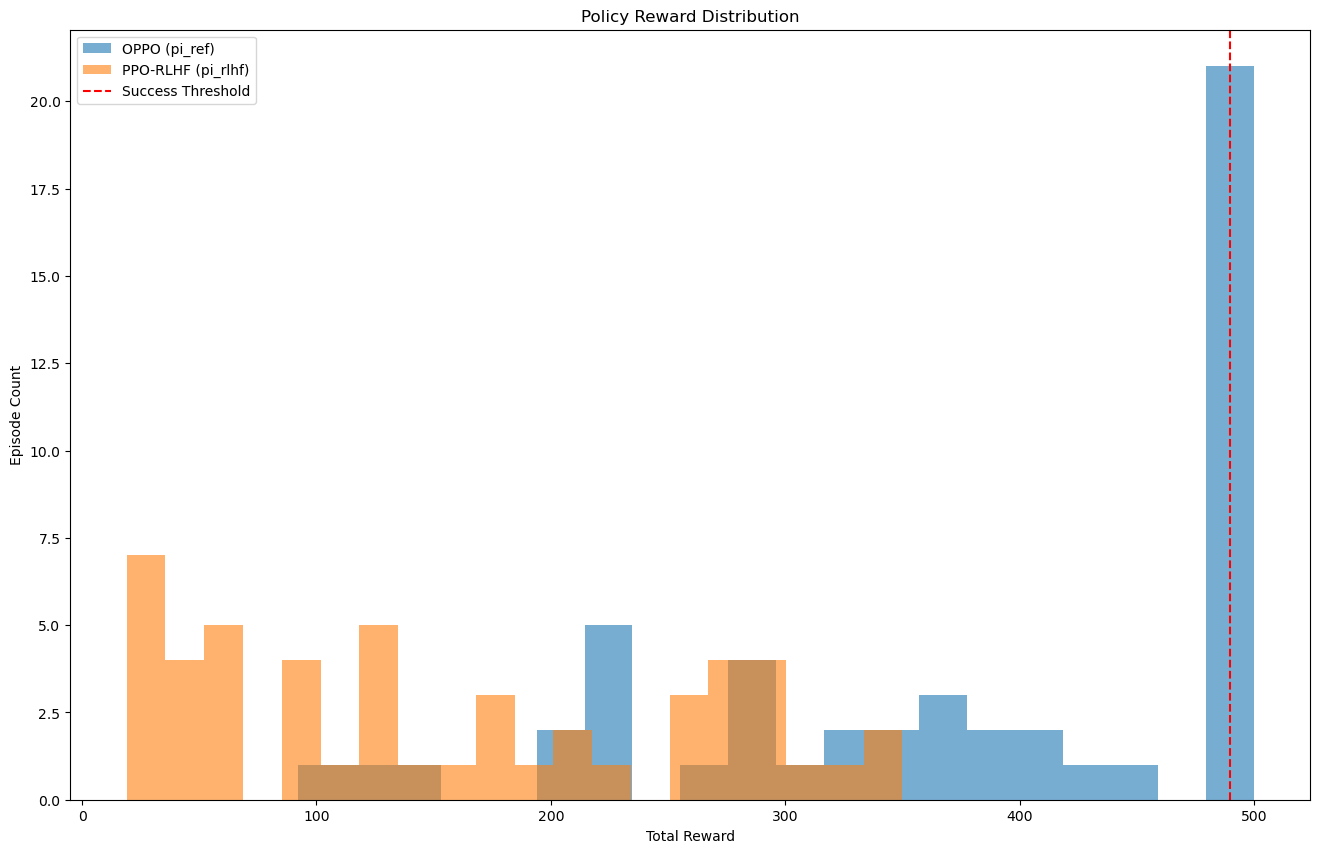

In [ ]:
# env_name = 'CartPole-v1'
# env = gym.make(env_name)


# pi_ref = Policy_v3(state_size=env.observation_space.shape[0],
#                      action_size=env.action_space.n).to(device)
# pi_ref.load_state_dict(torch.load(f"pi1_oppo_{env_name}.pth"))

# pi_ref2 = Policy_v3(state_size=env.observation_space.shape[0],
#                      action_size=env.action_space.n).to(device)
# pi_ref2.load_state_dict(torch.load(f"pi2_oppo_{env_name}.pth"))


# n_episodes = 50

# compare_policies(env_name, pi_ref2, policy, n_episodes=n_episodes, seed=42, success_threshold=490)
